#Stylized QR Codes with Company Logos

This project uses Stable Diffusion with four layers of ControlNet in order to generate QR codes that contain a company logo and also generated imagery.

## Initial imports


In [ ]:
!pip uninstall torch torchvision -y
!pip install -q diffusers transformers git+https://github.com/huggingface/accelerate.git
!pip install -U xformers --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=b49d93abe87d55abb17123fa560f770d14d5387be617122a96364083f907fbdf
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler
import torch
import cv2
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from diffusers.utils import load_image
from controlnet_aux import LineartDetector, LineartAnimeDetector

print("PyTorch Version: ",torch.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

PyTorch Version:  2.1.1+cu121
Using the GPU!


/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

## Helper Functions

In [ ]:
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

def image_grid(imgs, rows, cols):
  w, h = imgs[0].size
  grid = Image.new("RGB", size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
    grid.paste(img, box=(i % cols * w, i // cols * h))

  return grid

## Class Definition

This class is a wrapper for the StableDiffusionControlNetPipeline. It takes the images as inputs along with the ControlNet parameters, perfroms the preprocessing for ControlNet and then runs the diffusion given the parameters.

In [ ]:
class QRCodeGenerator:
  def __init__(self):
    self.controlnet = [
        ControlNetModel.from_single_file("https://huggingface.co/ioclab/ioc-controlnet/blob/main/models/control_v1p_sd15_brightness.safetensors", torch_dtype=torch.float16, use_safetensors=True),
        ControlNetModel.from_pretrained("lllyasviel/control_v11f1e_sd15_tile", torch_dtype=torch.float16),
        ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_lineart", torch_dtype=torch.float16),
        ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_lineart", torch_dtype=torch.float16),
    ]

    self.pipe = StableDiffusionControlNetPipeline.from_single_file(
        "https://huggingface.co/emmajoanne/models/blob/main/revAnimated_v122.safetensors", controlnet=self.controlnet, torch_dtype=torch.float16
    )

    self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)

    self.pipe.enable_xformers_memory_efficient_attention()
    self.pipe.enable_model_cpu_offload()

    self.lineart = LineartDetector.from_pretrained("lllyasviel/Annotators")
    self.lineart_anime = LineartAnimeDetector.from_pretrained("lllyasviel/Annotators")

    self.generator = torch.Generator(device="cpu")

    self.negative_prompt = "NSFW,(ng_deepnegative_v1_75t:1.5), (easynegative:1.5),(worst quality:2), (low quality:2),(normal quality:2), low-res, low resolution, bad anatomy, bad hands, extra fingers, missing finger, missing fingers, bad feet, extra feet,((monochrome)),((grayscale)), watermark, number,"

  def preprocess_images(self, qr_code, logo):
    qr_code = qr_code.resize((512, 512), Image.LANCZOS)
    logo = logo.resize((512, 512), Image.LANCZOS)

    qr_tile = resize_for_condition_image(qr_code.copy(), 512)

    qr_blur = qr_code.copy()
    qr_blur.convert("L")
    qr_blur = qr_blur.filter(ImageFilter.GaussianBlur(3))

    logo = np.array(logo, dtype=np.uint8)
    logo_lineart = self.lineart(logo.copy())

    logo_lineart_anime = self.lineart_anime(logo.copy())

    images = [qr_blur, qr_tile, logo_lineart, logo_lineart_anime]
    return images

  def run_diffusion(self, images, prompt, num_batches, num_images_per_batch):
    image_batches = []

    seeds = [np.random.randint(0, 10000) for _ in range(num_batches)]

    for seed in seeds:
      generator = self.generator.manual_seed(seed)
      image_batch = self.pipe(
          prompt,
          images,
          num_inference_steps=20,
          generator=self.generator,
          negative_prompt=self.negative_prompt,
          num_images_per_prompt=num_images_per_batch,
          controlnet_conditioning_scale=self.controlnet_conditioning_scale,
          controlnet_guidance_start=self.controlnet_guidance_start,
          controlnet_guidance_end=self.controlnet_guidance_end
      ).images

      image_batches += image_batch

    return image_batches

  def generate_qr_code(self, qr_code, logo, prompt, num_batches, num_images_per_batch, controlnet_conditioning_scale=[0.3, 0.3, 0.5, 0.5], controlnet_guidance_start=[0.45, 0.1, 0.23, 0], controlnet_guidance_end=[0.7, 0.93, 1, 1]):
    self.controlnet_conditioning_scale = controlnet_conditioning_scale
    self.controlnet_guidance_start = controlnet_guidance_start
    self.controlnet_guidance_end = controlnet_guidance_end

    images = self.preprocess_images(qr_code, logo)
    image_batches = self.run_diffusion(images, prompt, num_batches, num_images_per_batch)
    grid = image_grid(image_batches, num_batches, num_images_per_batch)

    return grid, image_batches

## Example Usage

### Initialize Image Generator Class

In [ ]:
# initialize image generator
qr_code_generator = QRCodeGenerator()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:761: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")


### Define parameters for diffusion run

In [ ]:
# load images
qr_code = load_image('qr-test.jpg')
logo = load_image('nike.jpg')

# intialize prompt
prompt =  "Create an 8K high-resolution artwork featuring a prominent bright orange basketball, surrounded by dynamic ink explosions and elegant gold accents. Focus on high contrast, intricate details, and rich aesthetics, ideal for an 8K wallpaper. Apply 'lora:epi_noiseoffset 0:1' for enhanced artistry."

# hyperparams
controlnet_conditioning_scale=[0.3, 0.3, 0.5, 0.5]
controlnet_guidance_start=[0.45, 0.1, 0.23, 0]
controlnet_guidance_end=[0.7, 0.93, 1, 1]


num_batches = 4
num_images_per_batch = 4

### (In order to run on your machine you will need to use your own images)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

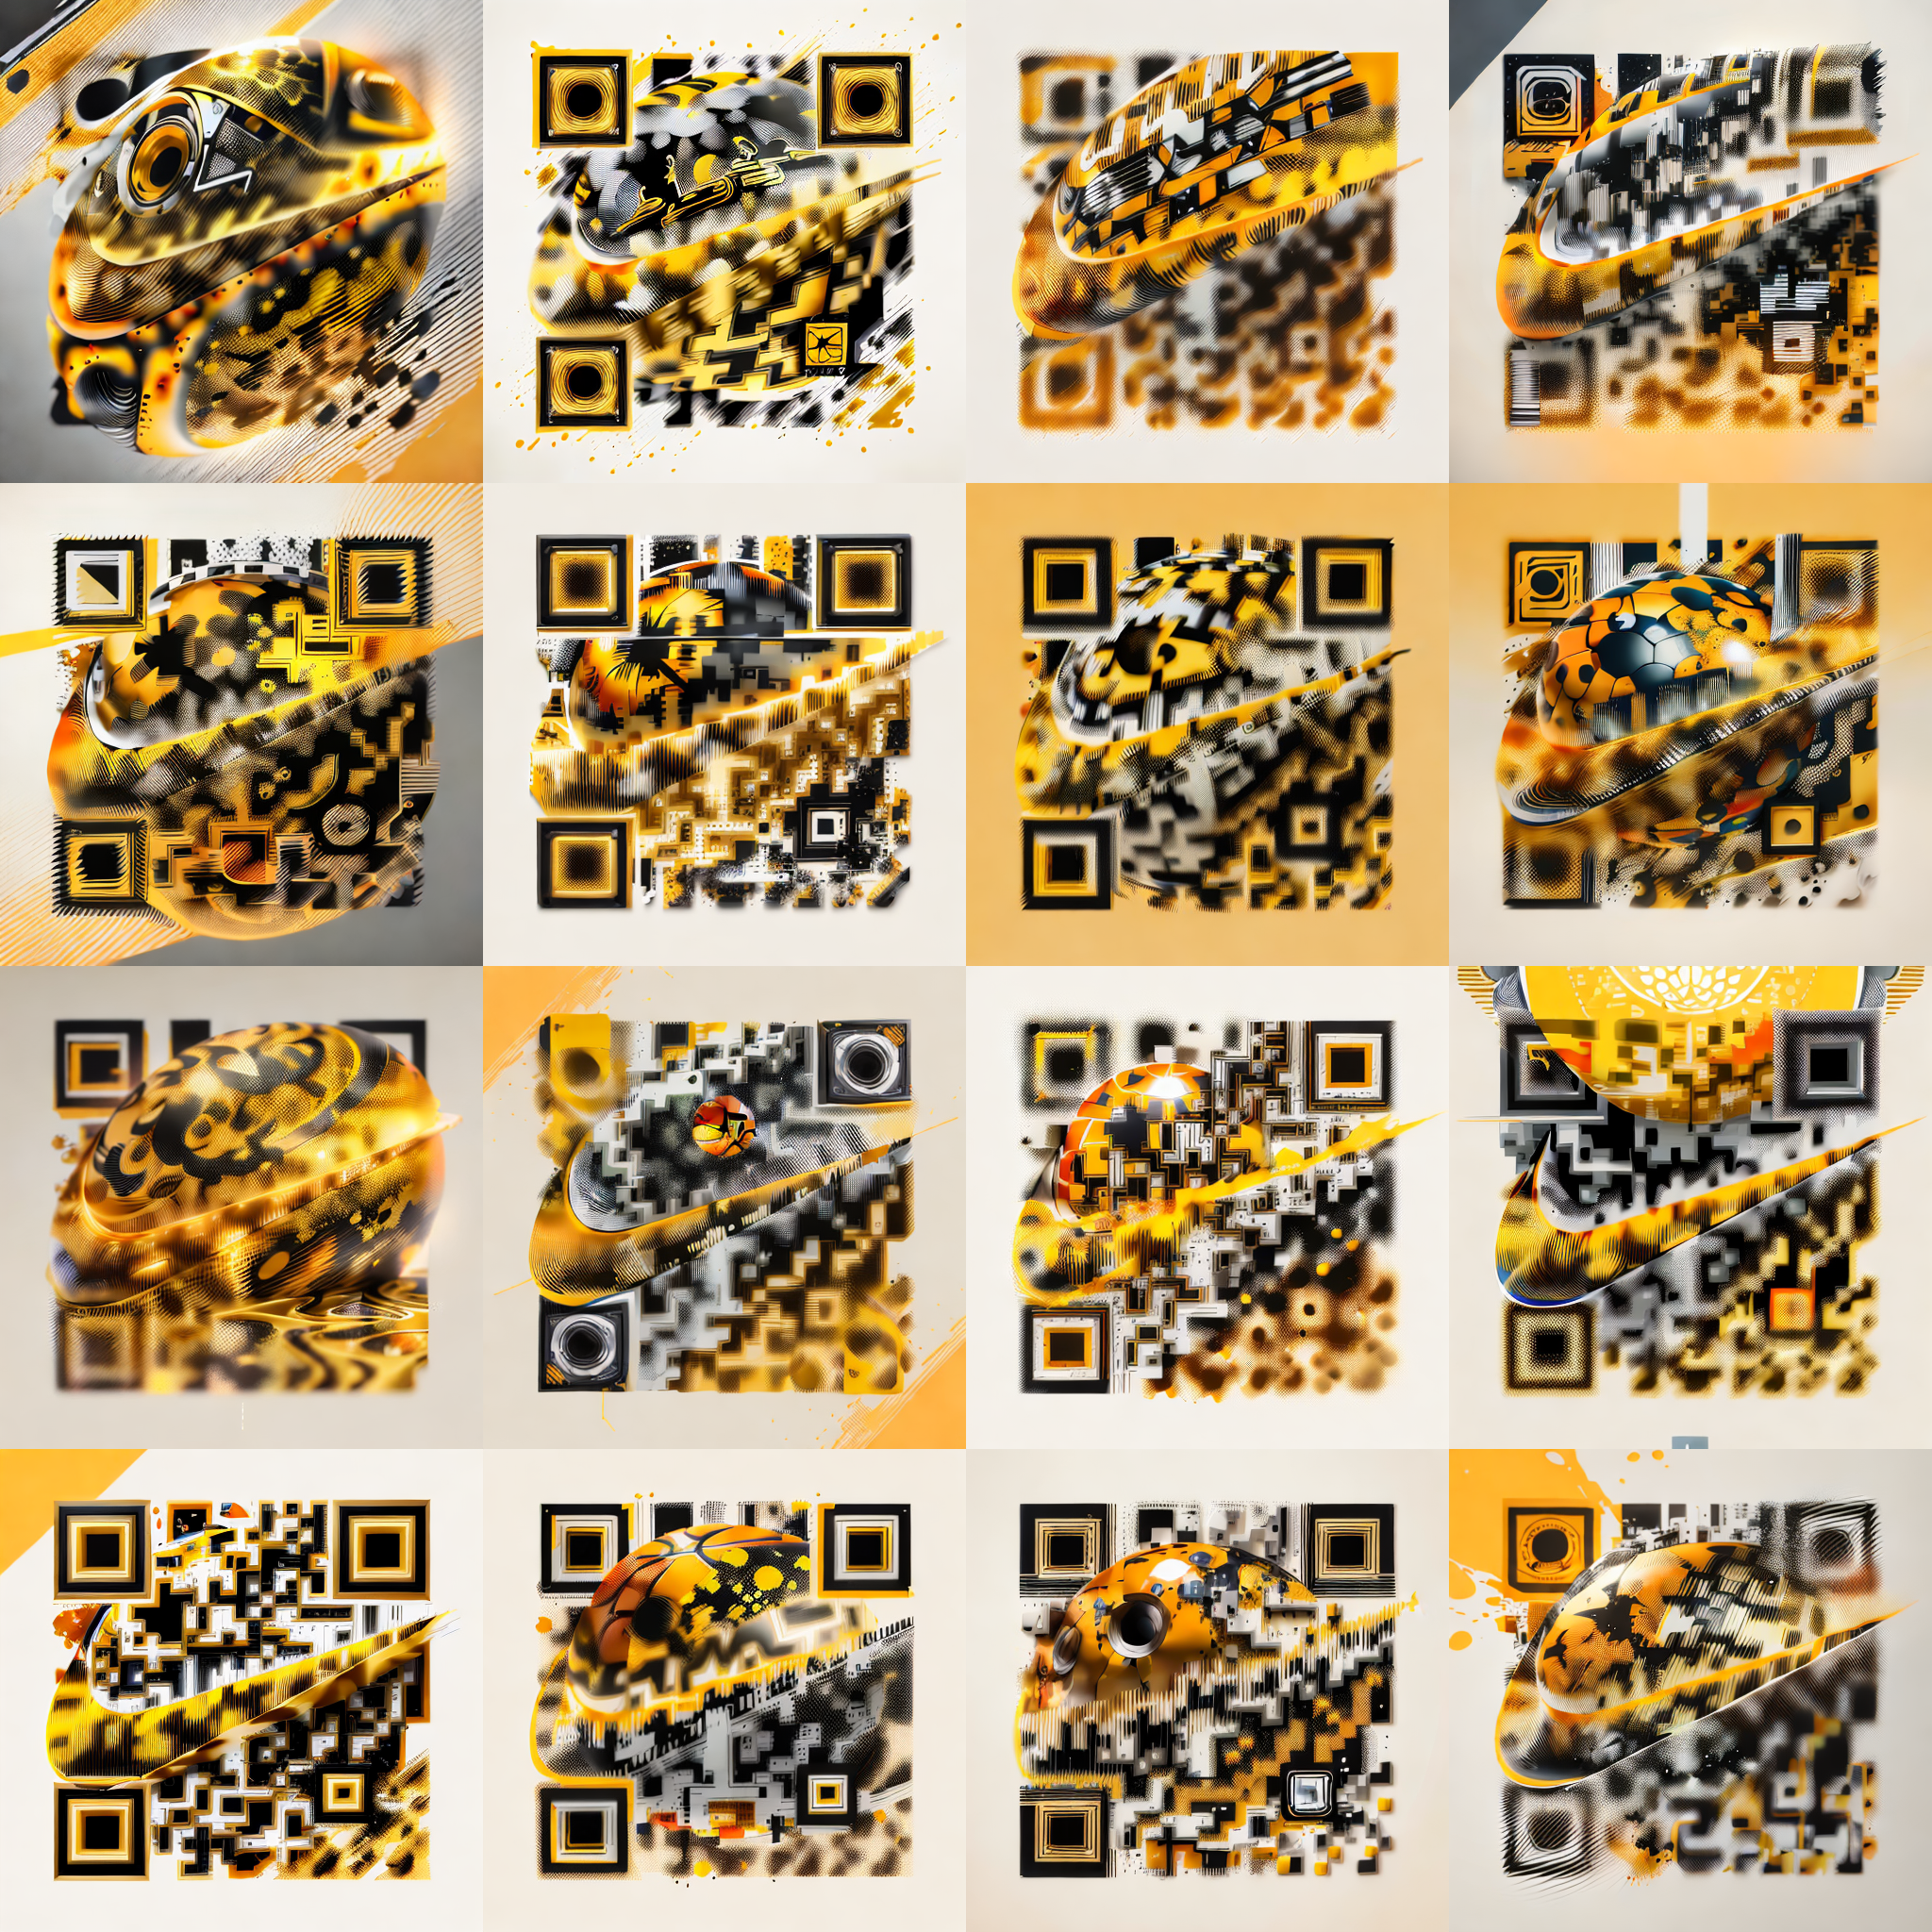

In [ ]:
grid, nike_images = qr_code_generator.generate_qr_code(qr_code, logo, prompt, num_batches, num_images_per_batch, controlnet_conditioning_scale, controlnet_guidance_start, controlnet_guidance_end)
grid